<a href="https://colab.research.google.com/github/danish-khan962/Deep-Learning/blob/main/06_transfer_learning_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tranfer learning with Tensorflow : Fine Tuning**

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning : **Fine Tuning**

## Creating Helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is a headache.


So it's a good idea to put functions we'll use again in a script that we can download and import in our notebooks.

Here are some helper functions we already created before : https://github.com/danish-khan962/Deep-Learning/blob/main/scripts/helper_functions.py

In [1]:
!wget https://raw.githubusercontent.com/danish-khan962/Deep-Learning/main/scripts/helper_functions.py

--2025-09-07 04:21:03--  https://raw.githubusercontent.com/danish-khan962/Deep-Learning/main/scripts/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-09-07 04:21:03 (76.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Getting data

This time we're going to see how we can use the pre-trained models within `tf.keras.applications` and apply them to our own problem.

In [3]:
# Get 10% of training data of 10 classes of Food 101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2025-09-07 04:21:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.141.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   232MB/s    in 0.7s    

2025-09-07 04:21:12 (232 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/trai

In [5]:
# Creating training and test directory paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [6]:
import tensorflow as tf
print("Tensorflow version we're using: ", tf.__version__)

Tensorflow version we're using:  2.19.0


In [7]:
IMG_SIZE=(224,224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
# Class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[2.06918365e+02 1.89918365e+02 1.69918365e+02]
   [2.03969391e+02 1.86969391e+02 1.66969391e+02]
   [2.03433670e+02 1.85872452e+02 1.67724487e+02]
   ...
   [8.53572464e+01 1.31428726e+02 1.87714493e+02]
   [1.06260422e+02 1.59974777e+02 2.23760544e+02]
   [1.29673401e+02 1.87959106e+02 2.51147919e+02]]

  [[2.08525513e+02 1.93591827e+02 1.76382645e+02]
   [2.11591843e+02 1.95862244e+02 1.79581635e+02]
   [2.06040817e+02 1.92841843e+02 1.75867355e+02]
   ...
   [9.84133606e+01 1.44255234e+02 2.00158325e+02]
   [1.14495041e+02 1.65347122e+02 2.29933945e+02]
   [1.25617302e+02 1.83903015e+02 2.50765259e+02]]

  [[1.99566330e+02 1.90857147e+02 1.75494904e+02]
   [1.96510208e+02 1.87755112e+02 1.73168365e+02]
   [1.91806107e+02 1.83448975e+02 1.68663254e+02]
   ...
   [9.04541931e+01 1.34265472e+02 1.88551224e+02]
   [1.11974701e+02 1.62984955e+02 2.25046249e+02]
   [1.28005051e+02 1.87290756e+02 2.48918320e+02]]

  ...

  [[5.37856712e+01 8.41428757e+01 6.93571396e+01]
   [5

## Modelling experiments we're running

| Experiment | Data | Preprocessing | Model |
| -------- | --------| ---------| ---------|
| Model 0(baseline) | 10 classes of Food101 (**random 10%** training data only)| None | **Feature Extractor:** EfficientNetb0 (pre-trained on ImageNet, all layers frozen) with no top |
| Model 1 | 10 classes of Food101 (**random 1%** training data only) | Random Flip, rotation, zoom, height, width, data augmentation | Same as Model 0 |
| Model 2 | Same as Model 0 | Same as model 1 | Same as Model 0 |
| Model 3 | Same as Model 0 | Same as Model 1 | **Fine tuning** Model 2 (EfficientnetB0 pre-trained on ImageNet) **with top layers trained on custom data, top 10 layers unfrozen** |
| Model 4 | 10 classes of Food101 (**random 100%** training data) | Same as Model 1 | Same as Model 3 |

## **Model 0:** Creating Model with Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models.

In [11]:
# 1. Creating baseline model with tf.keras.applications

base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't update during training)
base_model.trainable = False

# 3. Create inputs
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs
# (Don't have to normalize for EfficientNetB0)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs to base_model: {x.shape}")

# 6. Average pool the outputs (aggregate all most important information, reducing number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine inputs with outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=["accuracy"])

# 10. Fit the model
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch = len(train_data_10_percent),
                        validation_data = test_data,
                        validation_steps = int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="tranfer_learning",
                                                               experiment_name= "10_percent")])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Shape after passing inputs to base_model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: tranfer_learning/10_percent/20250907-042131
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.2420 - loss: 2.1460 - val_accuracy: 0.7533 - val_loss: 1.2955
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 132ms/step - accuracy: 0.7636 - loss: 1.1566 - val_accuracy: 0.8306 - val_loss: 0.8572
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.8264 - loss: 0.8267 - val_accuracy: 0.8635 - val_loss: 0.6793
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.8546 - loss: 0.6713 - val_accuracy: 0.8602 - val_loss: 0.6078
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.8793 - loss: 0.5582 - val_accuracy: 0.8569 - val_loss: 0.5605


In [12]:
model_0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - accuracy: 0.8706 - loss: 0.5501


[0.5539919137954712, 0.8704000115394592]

In [13]:
# Let's check summary of base model
base_model.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer[0][0] │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, None,      │          7 │ rescaling[0][0]   │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, None,      │          0 │ normalization[0]… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, None,      │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ stem_conv_pad[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, None,      │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, None,      │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, None,      │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, None,      │          0 │ block1a_activati… │
│ (Multiply)          │ None, 32)         │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [14]:
# Checking layers of model_0
model_0.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,088,003 (15.59 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 25,622 (100.09 KB)

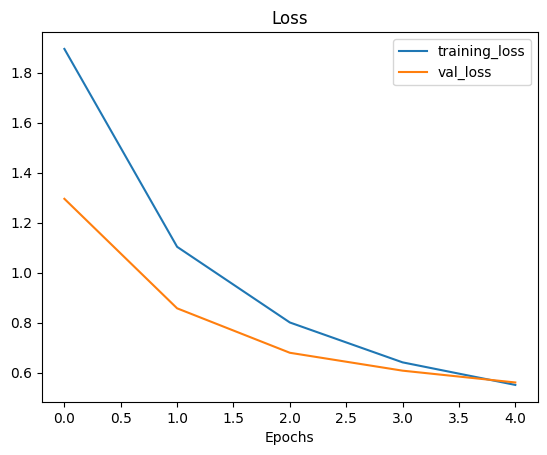

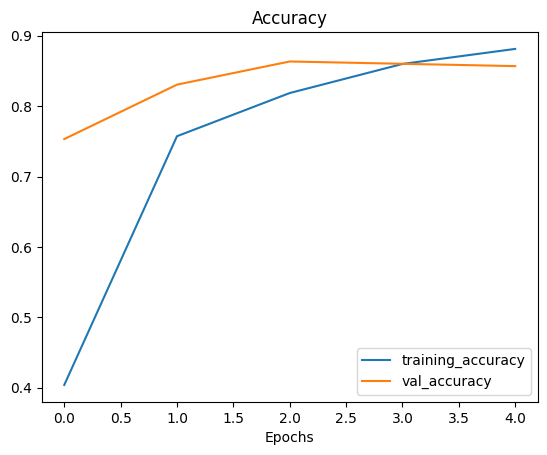

In [15]:
# Plotting loss curves
plot_loss_curves(history_0)

## Getting a feature vector from a trained model


Let's demonstrate the Global Average Pooling 2d Layer..


We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).


But then when it passes through `GlobalAveragePooling2D`, it turns into (None, 1280).


Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAvergaePooling2D.


In [17]:
# Define the input shape
input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]


In [19]:
# Passing the random tensor to Global Avergae Pooling 2D
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"Shape of tensor after passing through GlobalAveragePooling2D: {global_average_pooled_tensor.shape}")
print(f"2D avergae pooled random tensor: \n {global_average_pooled_tensor}")

Shape of tensor after passing through GlobalAveragePooling2D: (1, 3)
2D avergae pooled random tensor: 
 [[-0.09368646 -0.45840448 -0.2885598 ]]


In [20]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments

We've see the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data.. how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation.
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation.
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation.


**Note:** Throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

In [21]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2025-09-07 05:11:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.141.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   160MB/s    in 0.8s    

2025-09-07 05:11:19 (160 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [23]:
# Creating training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [24]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There a

In [25]:
# Setup data loaders
IMG_SIZE=(224,224)

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Adding data a